In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import matplotlib.ticker as mtick

## Bronze Layer

In [2]:
### Ingesting data from Google Cloud Storage

bucket_name = "cs611_mle"
members_path_in_bucket = "Data Source/members.csv"
transactions_path_in_bucket = "Data Source/transactions.csv"
user_logs_path_in_bucket = "Data Source/user_logs.csv"

members_gcs_path = f"gs://{bucket_name}/{members_path_in_bucket}"
transactions_gcs_path = f"gs://{bucket_name}/{transactions_path_in_bucket}"
user_logs_gcs_path = f"gs://{bucket_name}/{user_logs_path_in_bucket}"

df_members = pd.read_csv(members_gcs_path)
df_transactions = pd.read_csv(transactions_gcs_path)
df_logs = pd.read_csv(user_logs_gcs_path)

In [3]:
print(f"members:{df_members.shape}")
print(f"transactions:{df_transactions.shape}")
print(f"logs:{df_logs.shape}")

members:(300000, 7)
transactions:(3406383, 10)
logs:(61325062, 10)


In [4]:
print("------------------members.information---------------")
print(df_members.info())
print("------------------transactions.information---------------")
print(df_transactions.info())
print("------------------user_logs.information---------------")
print(df_logs.info())

------------------members.information---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unnamed: 0              300000 non-null  int64 
 1   msno                    300000 non-null  object
 2   city                    300000 non-null  int64 
 3   bd                      300000 non-null  int64 
 4   gender                  128468 non-null  object
 5   registered_via          300000 non-null  int64 
 6   registration_init_time  300000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 16.0+ MB
None
------------------transactions.information---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406383 entries, 0 to 3406382
Data columns (total 10 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Unnamed: 0              int64 
 1   msno                

In [ ]:
# create bronze tables and store to Google Cloud Storage
bronze_members_file_path = "Bronze Layer/bronze_members.csv"
bronze_transactions_file_path = "Bronze Layer/bronze_transactions.csv"
bronze_user_logs_file_path = "Bronze Layer/df_user_logs.csv"

bronze_members_gcs_path = f"gs://{bucket_name}/{bronze_members_file_path}"
bronze_transactions_gcs_path = f"gs://{bucket_name}/{bronze_transactions_file_path}"
bronze_user_logs_gcs_path = f"gs://{bucket_name}/{bronze_user_logs_file_path}"

try:
    df_members.to_csv(bronze_members_gcs_path, index=False)
    print("bronze_members.csv Stored to Bronze Layer Successfully! ✅")
except Exception as e:
    print(f"bronze_members.csv Store Failed: {e}")

try:
    df_transactions.to_csv(bronze_transactions_gcs_path, index=False)
    print("bronze_transactions.csv Stored to Bronze Layer Successfully! ✅")
except Exception as e:
    print(f"bronze_transactions.csv Store Failed: {e}")

try:
    df_logs.to_csv(bronze_user_logs_gcs_path, index=False)
    print("df_user_logs.csv Stored to Bronze Layer Successfully! ✅")
except Exception as e:
    print(f"df_user_logs.csv Store Failed: {e}")

bronze_members.csv Stored to Bronze Layer Successfully！✅
bronze_transactions.csv Stored to Bronze Layer Successfully！✅
df_user_logs.csv Stored to Bronze Layer Successfully！✅


## Silver Layer

To determine a user is churn or not, it should be based on transaction details. Therefore, in label engineering, only transaction.csv will be processed by medallion architecture. Other tables will be proceesed in feature engineering. 

In [5]:
df_transactions = df_transactions.iloc[:, 1:]
df_transactions['transaction_date']=pd.to_datetime(df_transactions['transaction_date'], format='%Y%m%d')
df_transactions['membership_expire_date']=pd.to_datetime(df_transactions['membership_expire_date'], format='%Y%m%d')
df_transactions = df_transactions.sort_values(by=['msno','transaction_date'])
df_transactions

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1245059,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
3046991,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
1946519,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
504358,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
1623538,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,129,1,2015-05-04,2015-06-09,0
...,...,...,...,...,...,...,...,...,...
734725,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-11-30,2017-01-24,0
277316,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-12-31,2017-02-24,0
298762,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-01-31,2017-03-24,0
3398488,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,2017-04-24,0


In [6]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3406383 entries, 1245059 to 3257080
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   payment_method_id       int64         
 2   payment_plan_days       int64         
 3   plan_list_price         int64         
 4   actual_amount_paid      int64         
 5   is_auto_renew           int64         
 6   transaction_date        datetime64[ns]
 7   membership_expire_date  datetime64[ns]
 8   is_cancel               int64         
dtypes: datetime64[ns](2), int64(6), object(1)
memory usage: 259.9+ MB


In [7]:
df_transactions.isna().sum()

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

In [8]:
df_transactions.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,3.406383e+06,3.406383e+06,3.406383e+06,3.406383e+06,3.406383e+06,3406383,3406383,3.406383e+06
mean,3.939665e+01,3.155030e+01,1.446823e+02,1.473133e+02,9.215306e-01,2016-02-27 22:07:30.980878336,2016-04-16 20:53:10.746314240,5.578380e-02
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015-01-01 00:00:00,1970-01-01 00:00:00,0.000000e+00
25%,3.900000e+01,3.000000e+01,1.290000e+02,1.290000e+02,1.000000e+00,2015-08-07 00:00:00,2015-09-27 00:00:00,0.000000e+00
50%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2016-02-28 00:00:00,2016-04-23 00:00:00,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2016-09-27 00:00:00,2016-11-10 00:00:00,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2017-03-31 00:00:00,2023-08-17 00:00:00,1.000000e+00
std,3.097484e+00,2.936009e+01,1.253914e+02,1.246733e+02,2.689089e-01,NaN,NaN,2.295038e-01


In [9]:
daily_transactions_by_user = df_transactions.groupby(['msno', 'transaction_date', 'is_cancel']).size().reset_index(name='transaction_count')
daily_transactions_by_user = daily_transactions_by_user.sort_values(by = 'transaction_count', ascending = False)
daily_user_counts_by_transactions = daily_transactions_by_user.groupby(['transaction_count']).size().reset_index(name = 'counts')
daily_user_counts_by_transactions['cumsum'] =daily_user_counts_by_transactions['counts'].cumsum() 
daily_user_counts_by_transactions['proportion'] = daily_user_counts_by_transactions['cumsum']/daily_user_counts_by_transactions['counts'].sum()
daily_user_counts_by_transactions

,transaction_count,counts,cumsum,proportion
0,1,3349080,3349080,0.991825
1,2,26563,3375643,0.999692
2,3,758,3376401,0.999916
3,4,148,3376549,0.999960
4,5,44,3376593,0.999973
5,6,31,3376624,0.999983
6,7,8,3376632,0.999985
7,8,9,3376641,0.999988
8,9,5,3376646,0.999989
9,10,6,3376652,0.999991


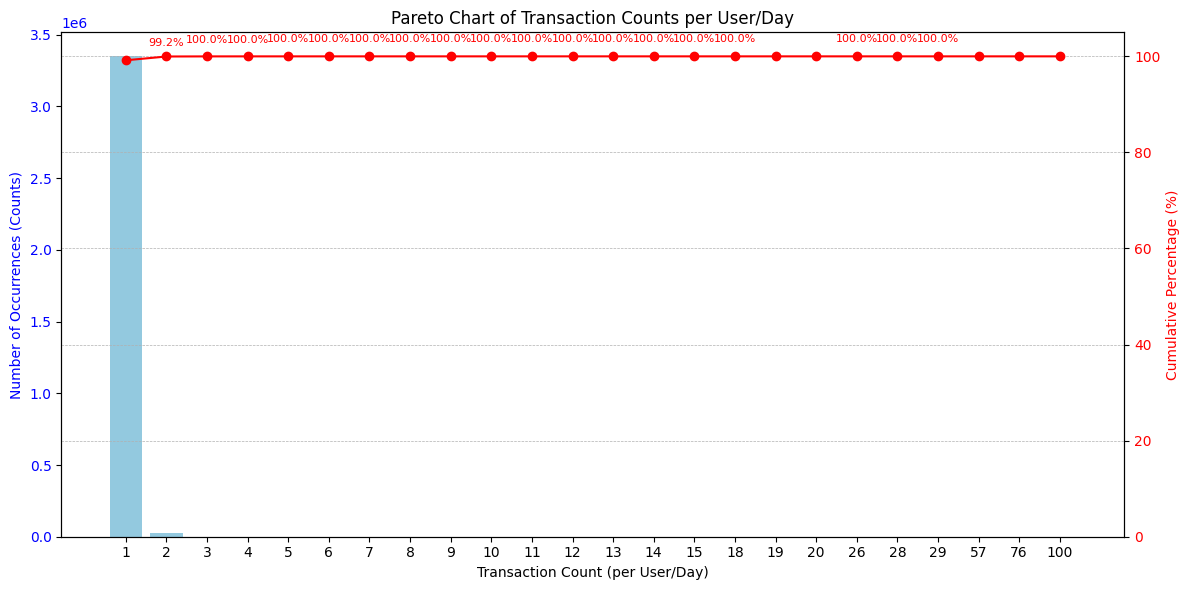

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))


sns.barplot(x='transaction_count', y='counts', data=daily_user_counts_by_transactions, ax=ax1, color='skyblue')
ax1.set_xlabel('Transaction Count (per User/Day)')
ax1.set_ylabel('Number of Occurrences (Counts)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Pareto Chart of Transaction Counts per User/Day')

ax2 = ax1.twinx()
ax2.plot(daily_user_counts_by_transactions['transaction_count'].astype(str), 
         daily_user_counts_by_transactions['proportion'] * 100, 
         color='red', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105) 

for index, row in daily_user_counts_by_transactions.iterrows():
    ax2.annotate(f'{row["proportion"]:.1%}',
                 (row['transaction_count'], row['proportion'] * 100),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')


plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [11]:
outlier_user_list = list(daily_transactions_by_user[daily_transactions_by_user['transaction_count'] > 2]['msno'].unique())
filtering = lambda x: True if x not in outlier_user_list else False
df_transactions['filtered'] = df_transactions['msno'].apply(filtering)

In [12]:
# check proportions of records of outlier users
df_transactions[df_transactions['filtered'] == False].shape[0]/df_transactions.shape[0]

0.004605765118015208

In [13]:
df_transactions = df_transactions[df_transactions['filtered'] == True]
df_transactions = df_transactions.drop(columns = ['filtered'])
df_transactions

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1245059,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
3046991,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
1946519,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
504358,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
1623538,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,129,1,2015-05-04,2015-06-09,0
...,...,...,...,...,...,...,...,...,...
734725,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-11-30,2017-01-24,0
277316,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-12-31,2017-02-24,0
298762,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-01-31,2017-03-24,0
3398488,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,2017-04-24,0


In [14]:
df_transactions = df_transactions[df_transactions['membership_expire_date'] >= '2015-01-01']
df_transactions

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1245059,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
3046991,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
1946519,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
504358,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
1623538,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,129,1,2015-05-04,2015-06-09,0
...,...,...,...,...,...,...,...,...,...
734725,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-11-30,2017-01-24,0
277316,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-12-31,2017-02-24,0
298762,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-01-31,2017-03-24,0
3398488,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,2017-04-24,0


In [15]:
# create silver table and store to Google Cloud Storage
siver_transactions_file_path = "Silver Layer/silver_transactions.csv"
silver_transactions_gcs_path = f"gs://{bucket_name}/{siver_transactions_file_path}"

try:
    df_transactions.to_csv(silver_transactions_gcs_path, index=False)
    print("silver_transactions.csv Stored to Silver Layer Successfully! ✅")
except Exception as e:
    print(f"silver_transactions.csv Store Failed: {e}")


silver_transactions.csv Stored to Silver Layer Successfully! ✅


## EDA

In [50]:
filtered_msno = df_transactions.groupby('msno')['is_cancel'].agg(set).reset_index()
filtered_msno = filtered_msno[filtered_msno['is_cancel'] == {0, 1}]
filtered_msno

,msno,is_cancel
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,"{0, 1}"
2,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,"{0, 1}"
3,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,"{0, 1}"
4,++8dXbkKMJ0rXwUc/m19lTVokEl3c9EfRKWmV6qP9jg=,"{0, 1}"
5,++BQyzVEMoHru900mTyAKpCsKYjXUGdAXylmmiPsbVY=,"{0, 1}"
...,...,...
189623,zzwsW1MnZalh6V5BwYE+V6hFWyKJYOf+rFd+SWVXxp8=,"{0, 1}"
189624,zzx4MmvaZjgHvBcOfqPX4PZPpo1FBuOrCbJMn+g9g7E=,"{0, 1}"
189625,zzx4hKiyR9XFEGAr7SAjcCPbKJCZ+IqegWL7dPjPwZk=,"{0, 1}"
189626,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,"{0, 1}"


In [51]:
filtered_transactions = df_transactions[df_transactions['msno'].isin(filtered_msno['msno'])]
filtered_transactions

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1245059,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
3046991,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
1946519,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
504358,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
1623538,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,129,1,2015-05-04,2015-06-09,0
...,...,...,...,...,...,...,...,...,...
734725,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-11-30,2017-01-24,0
277316,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2016-12-31,2017-02-24,0
298762,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-01-31,2017-03-24,0
3398488,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,2017-04-24,0


In [52]:
filtered_transactions = filtered_transactions.sort_values(by=['msno', 'transaction_date']).reset_index(drop=True)
result = []

for msno, group in filtered_transactions.groupby('msno'):
    group = group.sort_values(by='transaction_date')
    
    # find the first record of is_cancel = 1 for each msno
    cancel_record = group[group['is_cancel'] == 1].iloc[0] if (group['is_cancel'] == 1).any() else None
    
    if cancel_record is not None:
        # find the first record of is_cancel = 0 after the is_cancel = 1 record for each msno
        after_cancel = group[group['transaction_date'] >= cancel_record['transaction_date']]
        resume_record = after_cancel[after_cancel['is_cancel'] == 0].iloc[0] if (after_cancel['is_cancel'] == 0).any() else None
        
        if resume_record is not None:
            if resume_record['membership_expire_date'] >= cancel_record['membership_expire_date']:
                days_diff = (resume_record['transaction_date'] - cancel_record['membership_expire_date']).days
                result.append({
                    'msno': msno,
                    'expire_date': cancel_record['membership_expire_date'],
                    'resume_date': resume_record['transaction_date'],
                    'days_diff': days_diff
                })

result_df = pd.DataFrame(result)
result_df.loc[result_df['days_diff'] < 0, 'days_diff'] = 0
result_df

,msno,expire_date,resume_date,days_diff
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-05-04,0
1,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2016-03-04,2016-03-12,8
2,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,2015-06-14,2015-06-22,8
3,++8dXbkKMJ0rXwUc/m19lTVokEl3c9EfRKWmV6qP9jg=,2016-08-05,2016-08-05,0
4,++BQyzVEMoHru900mTyAKpCsKYjXUGdAXylmmiPsbVY=,2015-12-29,2015-12-28,0
...,...,...,...,...
150656,zzwsW1MnZalh6V5BwYE+V6hFWyKJYOf+rFd+SWVXxp8=,2015-11-05,2015-10-09,0
150657,zzx4MmvaZjgHvBcOfqPX4PZPpo1FBuOrCbJMn+g9g7E=,2015-07-13,2015-11-06,116
150658,zzx4hKiyR9XFEGAr7SAjcCPbKJCZ+IqegWL7dPjPwZk=,2016-12-19,2016-12-19,0
150659,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,2015-05-14,2015-05-15,1


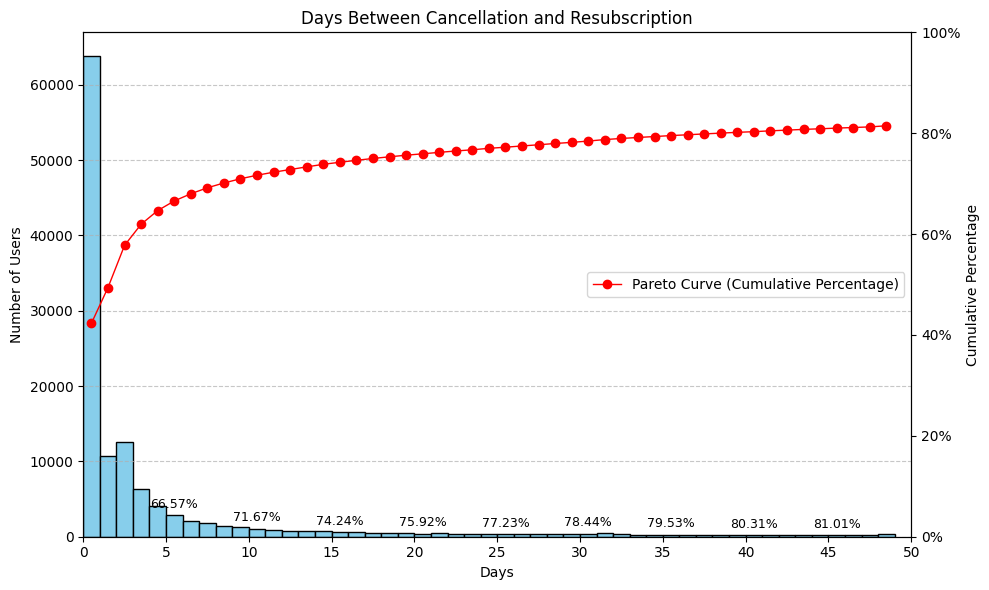

In [53]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(result_df['days_diff'], bins=range(0, 50), color='skyblue', edgecolor='black')

plt.xlim(0, 50)
plt.xticks(range(0, 51, 5))
plt.title('Days Between Cancellation and Resubscription')
plt.xlabel('Days')
plt.ylabel('Number of Users')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

total_count = len(result_df)
x_ticks_to_label = [5, 10, 15, 20, 25, 30, 35, 40, 45]

for x in x_ticks_to_label:
    if x >= len(bins):
        continue
    
    count_less_than_x = result_df[result_df['days_diff'] <= x].shape[0]
    proportion = count_less_than_x / total_count

    bin_index = x  
    patch = patches[bin_index]  
    
    height = patch.get_height()
    bin_center = 0.5 * (bins[bin_index] + bins[bin_index + 1])

    plt.text(
        bin_center,
        height + 1000, 
        f'{proportion:.2%}',
        ha='center',
        fontsize=9,
        rotation=0
    )


ax2 = plt.twinx()
cumulative_n = n.cumsum()
cumulative_percentage = cumulative_n / total_count
bin_centers = (bins[:-1] + bins[1:]) / 2
ax2.plot(bin_centers, cumulative_percentage, color='red', marker='o', linestyle='-', linewidth=1, label='Pareto Curve (Cumulative Percentage)')
ax2.set_ylim(0, 1) 
ax2.set_ylabel('Cumulative Percentage')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
lines, labels = ax2.get_legend_handles_labels()
plt.legend(lines, labels, loc='center right')

plt.tight_layout()
plt.show()

## Gold Layer

In [54]:
bins = [-1, 5, np.inf]  
labels = [0, 1]  
result_df['label'] = pd.cut(result_df['days_diff'], bins=bins, labels=labels, right=True)
result_df

,msno,expire_date,resume_date,days_diff,label
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-05-04,0,0
1,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2016-03-04,2016-03-12,8,1
2,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,2015-06-14,2015-06-22,8,1
3,++8dXbkKMJ0rXwUc/m19lTVokEl3c9EfRKWmV6qP9jg=,2016-08-05,2016-08-05,0,0
4,++BQyzVEMoHru900mTyAKpCsKYjXUGdAXylmmiPsbVY=,2015-12-29,2015-12-28,0,0
...,...,...,...,...,...
150656,zzwsW1MnZalh6V5BwYE+V6hFWyKJYOf+rFd+SWVXxp8=,2015-11-05,2015-10-09,0,0
150657,zzx4MmvaZjgHvBcOfqPX4PZPpo1FBuOrCbJMn+g9g7E=,2015-07-13,2015-11-06,116,1
150658,zzx4hKiyR9XFEGAr7SAjcCPbKJCZ+IqegWL7dPjPwZk=,2016-12-19,2016-12-19,0,0
150659,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,2015-05-14,2015-05-15,1,0


In [55]:
filtered_msno['label'] = 1
filtered_msno.set_index('msno', inplace=True)
filtered_msno = filtered_msno.drop('is_cancel', axis=1)
filtered_msno

,label
msno,
++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,1
++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,1
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,1
++8dXbkKMJ0rXwUc/m19lTVokEl3c9EfRKWmV6qP9jg=,1
++BQyzVEMoHru900mTyAKpCsKYjXUGdAXylmmiPsbVY=,1
...,...
zzwsW1MnZalh6V5BwYE+V6hFWyKJYOf+rFd+SWVXxp8=,1
zzx4MmvaZjgHvBcOfqPX4PZPpo1FBuOrCbJMn+g9g7E=,1
zzx4hKiyR9XFEGAr7SAjcCPbKJCZ+IqegWL7dPjPwZk=,1


In [56]:
print(filtered_msno.isnull().sum())
print(result_df.isnull().sum())
print(filtered_msno.dtypes)
print(result_df.dtypes)

label    0
dtype: int64
msno           0
expire_date    0
resume_date    0
days_diff      0
label          0
dtype: int64
label    int64
dtype: object
msno                   object
expire_date    datetime64[ns]
resume_date    datetime64[ns]
days_diff               int64
label                category
dtype: object


In [57]:
result_df.set_index('msno', inplace=True)
result_df['label'] = result_df['label'].astype(int)
result_df

,expire_date,resume_date,days_diff,label
msno,,,,
++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-05-04,0,0
++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2016-03-04,2016-03-12,8,1
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,2015-06-14,2015-06-22,8,1
++8dXbkKMJ0rXwUc/m19lTVokEl3c9EfRKWmV6qP9jg=,2016-08-05,2016-08-05,0,0
++BQyzVEMoHru900mTyAKpCsKYjXUGdAXylmmiPsbVY=,2015-12-29,2015-12-28,0,0
...,...,...,...,...
zzwsW1MnZalh6V5BwYE+V6hFWyKJYOf+rFd+SWVXxp8=,2015-11-05,2015-10-09,0,0
zzx4MmvaZjgHvBcOfqPX4PZPpo1FBuOrCbJMn+g9g7E=,2015-07-13,2015-11-06,116,1
zzx4hKiyR9XFEGAr7SAjcCPbKJCZ+IqegWL7dPjPwZk=,2016-12-19,2016-12-19,0,0


In [58]:
filtered_msno.update(result_df[['label']])
filtered_msno['label'] = filtered_msno['label'].astype(int)
filtered_msno

,label
msno,
++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,0
++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,1
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,1
++8dXbkKMJ0rXwUc/m19lTVokEl3c9EfRKWmV6qP9jg=,0
++BQyzVEMoHru900mTyAKpCsKYjXUGdAXylmmiPsbVY=,0
...,...
zzwsW1MnZalh6V5BwYE+V6hFWyKJYOf+rFd+SWVXxp8=,0
zzx4MmvaZjgHvBcOfqPX4PZPpo1FBuOrCbJMn+g9g7E=,1
zzx4hKiyR9XFEGAr7SAjcCPbKJCZ+IqegWL7dPjPwZk=,0


In [59]:
df_members['label'] = 0
df_members.set_index('msno', inplace=True)
label = df_members[['label']]
label

,label
msno,
2dwuk0KQUnCnRvFnDGFyIslHLqG8lFHkyOvfRNwc5XI=,0
Bx13MoR+nVJVVDsatg3fxInFupmO1jSzdkFKMA976t8=,0
2ouWnOhbWxdFyjEy8qx/8lr15OzZ0PX9tr6xZP4Ihns=,0
QvZtxnHz7yGh07QiFuq0RN1hL5WrzcbKlQTUiroEEyE=,0
CUFR22oaKwIwzj4VMey3Mj76B5zawuo2PxsWheNfQ6Q=,0
...,...
u2ZFhHBKeaNkXR5IWV88Id6zd5U6tc7Oxv/kVZ1ZQ/s=,0
Z3QAHHe2PwgA1TZM7aN7yIO4M6OoT2xdvccutBe6SmE=,0
Ut82CPYSqaueUjOrv47f9knp2qKcGGUTj3h+oXFBCy8=,0


In [60]:
label.update(filtered_msno[['label']])
label.reset_index(inplace=True)
label['label'] = label['label'].astype(int)
label

/tmp/ipykernel_54/788662609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label['label'] = label['label'].astype(int)


,msno,label
0,2dwuk0KQUnCnRvFnDGFyIslHLqG8lFHkyOvfRNwc5XI=,0
1,Bx13MoR+nVJVVDsatg3fxInFupmO1jSzdkFKMA976t8=,0
2,2ouWnOhbWxdFyjEy8qx/8lr15OzZ0PX9tr6xZP4Ihns=,0
3,QvZtxnHz7yGh07QiFuq0RN1hL5WrzcbKlQTUiroEEyE=,1
4,CUFR22oaKwIwzj4VMey3Mj76B5zawuo2PxsWheNfQ6Q=,0
...,...,...
299995,u2ZFhHBKeaNkXR5IWV88Id6zd5U6tc7Oxv/kVZ1ZQ/s=,0
299996,Z3QAHHe2PwgA1TZM7aN7yIO4M6OoT2xdvccutBe6SmE=,0
299997,Ut82CPYSqaueUjOrv47f9knp2qKcGGUTj3h+oXFBCy8=,0
299998,S84wwJdls1Zzv7+dKkhVgU1bbL6Laoo/tPNdFmzHlaA=,0


In [61]:
label.groupby('label').count()

,msno
label,
0,244430
1,55570


label
0    244430
1     55570
Name: count, dtype: int64
label
0    0.814767
1    0.185233
Name: proportion, dtype: float64


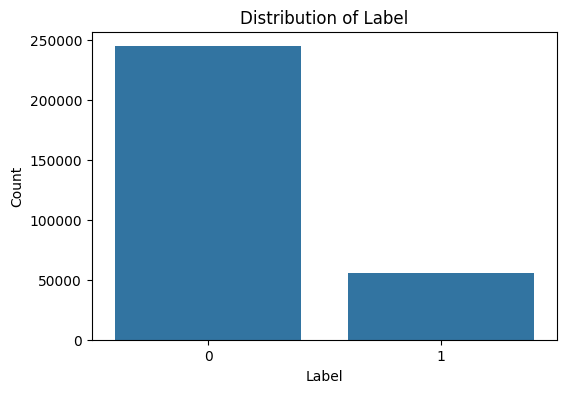

In [62]:
# label
print(label['label'].value_counts())
print(label['label'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=label)
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# create silver table and store to Google Cloud Storage
gold_label_file_path = "Gold Layer/label.csv"
gold_label_gcs_path = f"gs://{bucket_name}/{gold_label_file_path}"

try:
    label.to_csv(gold_label_gcs_path, index=False)
    print("Stored to Gold Layer Successfully! ✅")

except Exception as e:
    print(f"Store Failed: {e}")

Stored to Gold Layer Successfully！✅
